# Simple forecasting techniques

## The importance of a baseline model

In this notebook we will explore some simple forecasting techniques.  Selecting on of these simple techniques should on of your early decisions in a time series forecasting project. Although each represents simple approach to forecasting they are from a family of techniques used for setting a statistical baseline. Before you move onto complex methods make sure you use a benchmark or baseline.  Any complex model must be better than the baseline to be considered for forecasting.  This is a often a missed step in forecasting where there is a temptation to use complex methods.

The methods we will explore are:

* Average Forecast
* Naive Forecast 1
* Seasonal Naive
* Naive with Drift

We will also introduce **Prediction Intervals**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import sys

## `forecast-tools` imports

In [2]:
# if running in Google Colab install forecast-tools
if 'google.colab' in sys.modules:
    !pip install forecast-tools


In [3]:
from forecast_tools.datasets import load_emergency_dept

import forecast_tools
print(forecast_tools.__version__)

0.2.1


## Helper functions

In [4]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

## The ED arrivals dataset.

The dataset we will use represent daily adult (age > 18) arrivals to an Emergency Department.  The simulated observations are between Jan 2017 and Dec 2017.

In [5]:
ed_daily = load_emergency_dept()

In [6]:
ed_daily.index.min()

Timestamp('2017-01-22 00:00:00')

In [7]:
ed_daily.index.max()

Timestamp('2017-12-31 00:00:00')

### Visualise the time series

<Axes: xlabel='date'>

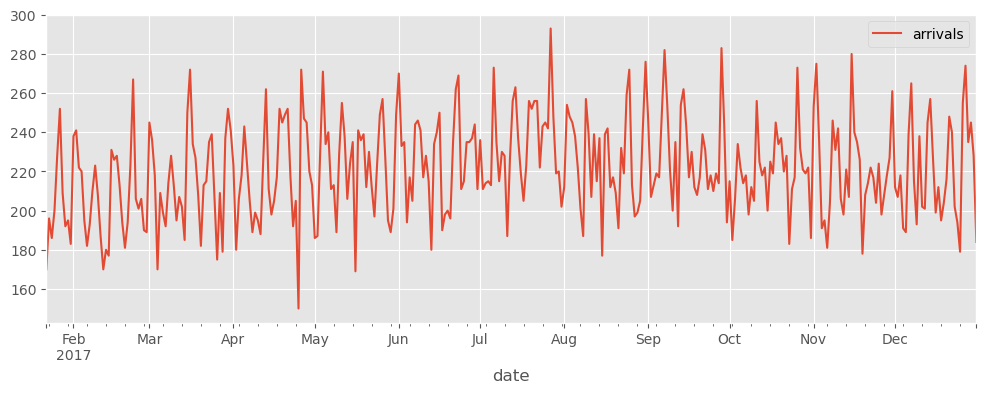

In [8]:
ed_daily.plot(figsize=(12,4))

## Mean Forecast

One of the simpliest baseline's is to take the average of the historical observations and project that forward. i.e. 

**The *mean forecast = sum of historical observations / number of historical values*.**

It is useful to write this in a slighly more compact mathematical form.

If the historical observation at time 1 = $y_1$ and at time 2 = $y_2$ the the times series can be represented as a series of observations between 1 and T (the final observation) $y_1, y_2 ... y_T$

The mean forecast given the historical observations $\hat{y}_{T+h|y_1, y_2 ... y_T}$ is therefore

$\hat{y}_{T+h|T} = \frac{\sum_{t=1}^{T}y_t}{T}$

PenCHORD has implemented some simple classes for baseline forecasts in a package called `forecast`.  

For a mean forecast the class to use is

```python
forecast_tools.baseline.Average
```

There are three steps to use it

* Create an instance of the class
* Call the `fit` method and pass in the historical data
* Call the `predict` method and pass in a chosen forecast horizon e.g. 28 days. 

In [9]:
#import the mean forecast class
from forecast_tools.baseline import Average

In [10]:
#create an instance of the average class
avg = Average()

In [11]:
#fit the historical data
avg.fit(ed_daily)

In [12]:
#call the predict method, choosing a prediction horizon
avg_preds = avg.predict(horizon=14)

In [13]:
#the method returns predictions as a numpy vector of length horizon.
avg_preds

array([221.06395349, 221.06395349, 221.06395349, 221.06395349,
       221.06395349, 221.06395349, 221.06395349, 221.06395349,
       221.06395349, 221.06395349, 221.06395349, 221.06395349,
       221.06395349, 221.06395349])

Let's visualise the forecast relative to the training data.

* Do you think this is a good baseline?

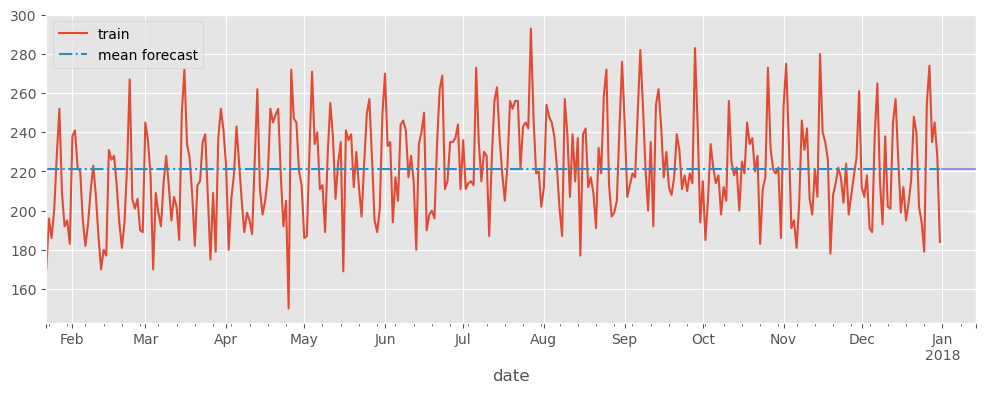

In [14]:
ax = ed_daily.plot(figsize=(12,4))
avg.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(ed_daily, avg_preds).plot(ax=ax)
ax.legend(['train', 'mean forecast'])

## Naive Forecast 1

An alternative and popular baseline forecast is Naive Forecast 1.  This simply takes the last value in the time series and extrapolates it forward over the forecast horizon.  I.e.

**Naive Forecast = Last value in the time series**

In mathematical notation:

$\hat{y}_{T+h|T} =y_t$

You can create a Naive1 forecast following the same steps as for the average forecast and using an object of type:
```python
forecast.baseline_tools.Naive1
```

In [15]:
from forecast_tools.baseline import Naive1

In [16]:
nf1 = Naive1()
nf1.fit(ed_daily)
nf1_preds = nf1.predict(horizon=28)

In [17]:
nf1_preds

array([184., 184., 184., 184., 184., 184., 184., 184., 184., 184., 184.,
       184., 184., 184., 184., 184., 184., 184., 184., 184., 184., 184.,
       184., 184., 184., 184., 184., 184.])

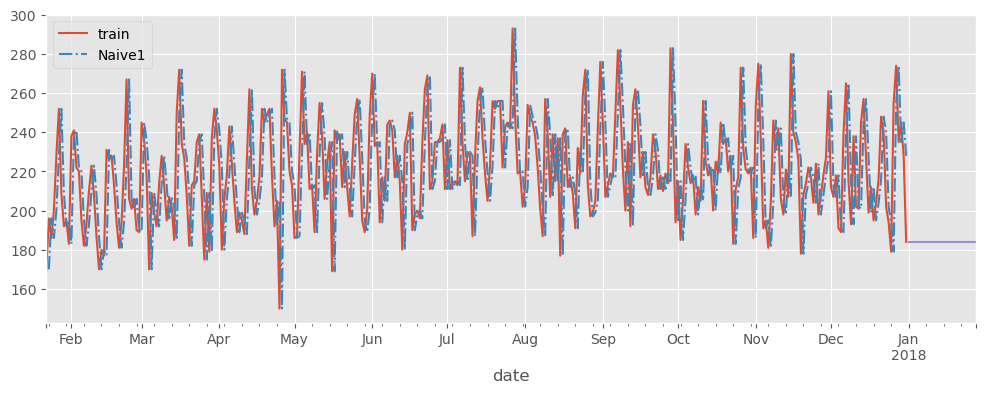

In [18]:
ax = ed_daily.plot(figsize=(12,4))
nf1.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(ed_daily, nf1_preds).plot(ax=ax)
ax.legend(['train', 'Naive1'])

## Seasonal Naive

Seasonal Naive extends Naive1 in an attempt to incorporate the seasonality in the data.  Instead of carrying the final value in the time series forward it carries forward the value from the previous time period.  As we are working with monthly data this means that a forecast for Janurary will use the previous Janurary's observation. A forecast for February will use the previous February's observation and so on.

In [19]:
from forecast_tools.baseline import SNaive

In [20]:
snf = SNaive(period=7)
snf.fit(ed_daily)
snf_preds = snf.predict(horizon=28)

In [21]:
snf_preds

array([179., 255., 274., 235., 245., 228., 184., 179., 255., 274., 235.,
       245., 228., 184., 179., 255., 274., 235., 245., 228., 184., 179.,
       255., 274., 235., 245., 228., 184.])

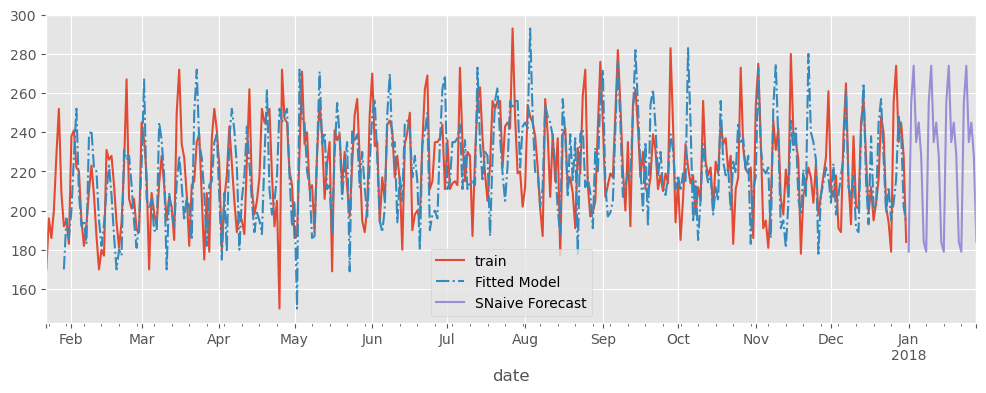

In [22]:
ax = ed_daily.plot(figsize=(12,4))
snf.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(ed_daily, snf_preds).plot(ax=ax)
ax.legend(['train','Fitted Model', 'SNaive Forecast'])

## Drift Method

So far the baseline methods have not considered an increasing or decreasing trend within the forecast.  A simple method to do this adjusting Naive1 to account for the average change in historical observations between the first period and the last.  This average change is called the **drift**.

In words the method is equivalent to taking a ruler and drawing a line between the first and last value in the series.  To forecast you then extend that line into the future for $h$ periods.

Mathematically a drift forecast is defined as:

$\hat{y}_{T+h|T} =y_t + h \left(\frac{y_T - y_1}{T - 1} \right)$


In [23]:
from forecast_tools.baseline import Drift

In [24]:
drf = Drift()
drf.fit(ed_daily)
drf_preds = drf.predict(horizon=28)

In [25]:
drf_preds

array([184.04081633, 184.08163265, 184.12244898, 184.16326531,
       184.20408163, 184.24489796, 184.28571429, 184.32653061,
       184.36734694, 184.40816327, 184.44897959, 184.48979592,
       184.53061224, 184.57142857, 184.6122449 , 184.65306122,
       184.69387755, 184.73469388, 184.7755102 , 184.81632653,
       184.85714286, 184.89795918, 184.93877551, 184.97959184,
       185.02040816, 185.06122449, 185.10204082, 185.14285714])

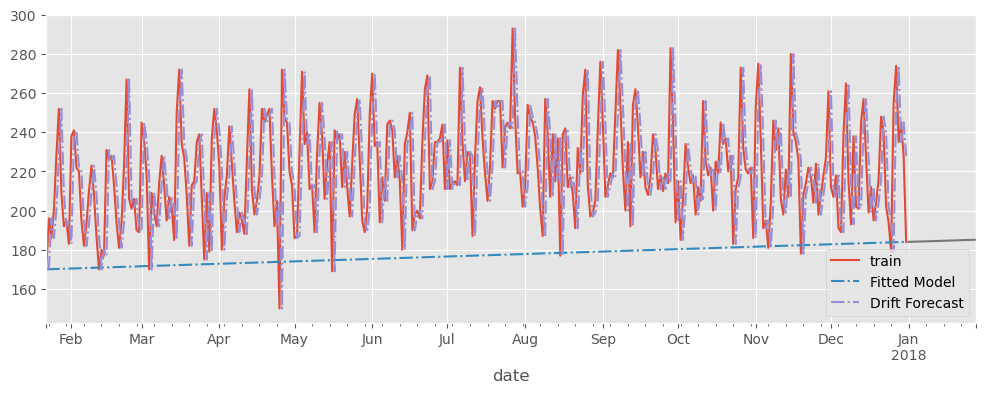

In [26]:
ax = ed_daily.plot(figsize=(12,4))
drf.fitted_gradient.plot(ax=ax, linestyle='-.')
drf.fittedvalues.plot(ax=ax, linestyle='dashdot')
preds_as_series(ed_daily, drf_preds).plot(ax=ax)
ax.legend(['train','Fitted Model', 'Drift Forecast'])

## Prediction Intervals

To return a prediction interval from a baseline forecast object use:

```python
y_preds, y_intervals = model.predict(horizon, return_predict_int=True)
```

By default this returns 80% and 90% PIs.  

To return only the 80% intervals use:

```python
y_preds, y_intervals = model.predict(horizon, 
                                     return_predict_int=True, 
                                     alpha=[0.2])
```

To return, the 80, 90 and 95% intervals use:


```python
y_preds, y_intervals = model.predict(horizon, 
                                     return_predict_int=True, 
                                     alpha=[0.2,0.1,0.05])
```

In [27]:
def plot_prediction_intervals(train, preds, intervals, test=None):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    ax = train.plot(figsize=(12,4))

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', '_ignore',
                   '_ignore', '90%PI'], loc=2)
    
    

In [28]:
snf = SNaive(period=7)
snf.fit(ed_daily)
y_preds, y_intervals1 = snf.predict(horizon=6, return_predict_int=True, alpha=[0.2, 0.05])

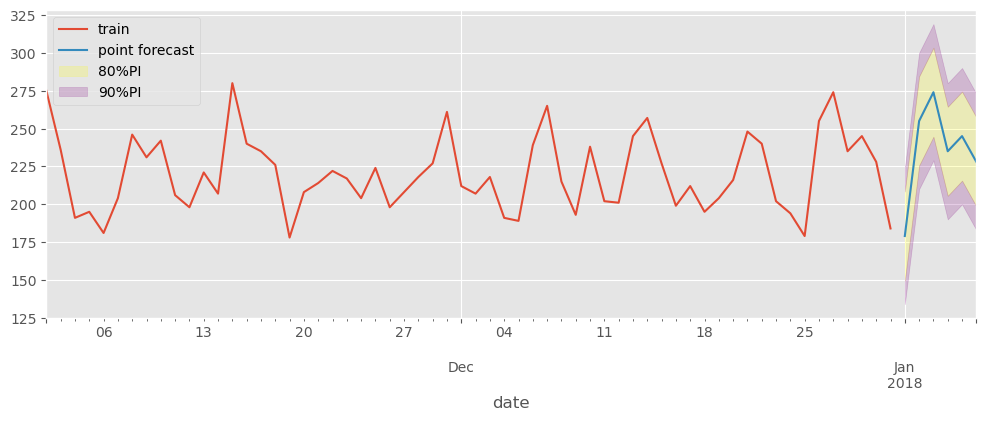

In [29]:
plot_prediction_intervals(ed_daily[-60:], y_preds, y_intervals1)

## Prediction Intervals via the Bootstrap

In [30]:
from forecast_tools.baseline import boot_prediction_intervals

In [31]:
y_intervals = boot_prediction_intervals(y_preds, snf.resid, 6, boots=1000, levels=[0.8, 0.95])

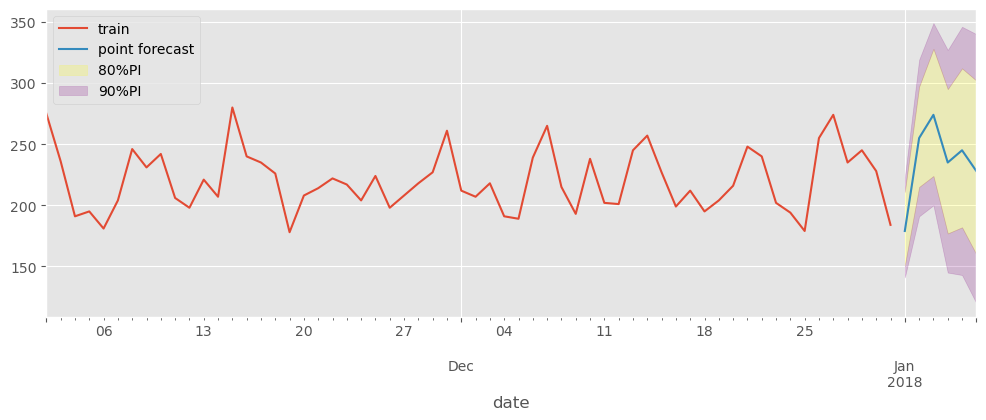

In [32]:
plot_prediction_intervals(ed_daily[-60:], y_preds, y_intervals)